In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
#import pyDOE
from sepia.SepiaModelSetup import setup_model
from sepia.SepiaData import SepiaData
datadir = "data/data_ball_drop_2/"

Consider a situation similar to the previous ball drop example; however, now consider different types of balls that have different densities. The four types of balls, baseball, basketball, bowling ball, and softball, are again dropped from a tower. Each type of ball has a unique radius $R$ and density $\rho$. Each ball is dropped from heights of 20, 40, and 60 meters.

We will generate synthetic experimental data from:
\begin{equation}
\frac{d^2h}{dt^2} = g - \frac{C}{2}\frac{3\rho_{air}}{4R_{ball}\rho_{ball}}\bigg(\frac{dh}{dt}\bigg)^2
\end{equation}
where $\rho_{air}=1.184 kg/m^3$ is the density of air, $R_{ball}$ is the radius of the ball, $\rho_{ball}$ is the density of the ball, and $g$ and $C$ are the coefficients of gravity and drag as defined in our previous example. The observation data model is given by equation (1) and $g$ and $C$ are both considered unknown. The goal is to jointly estimate these parameters.

There are three experiments for each type of ball corresponding to the heights of 20, 40, and 60 meters. The baseball, basketball, bowling ball, and softball have radii $0.0380, 0.12, 0.11, 0.0485$ meters and densities $626, 84, 1304, 380.9 \; kg/m^3$. A space filling Latin hypercube design selects the m=20 (C,g) design pairs for the simulator runs, shown in a scatter below. The simulator produces a curve of n=100 height-time pairs, where the simulation heights are evenly spaced in $[0,100]$ meters. Each of these 20 parameter settings are run for each of the four balls.

Read in data

x       : Radius and Density for Baseball, Basketball, Bowling Ball, Softball  
t_sim   : LH generated simulation design points  
h_field : oberservational heights for each experiment  
h_sim   : simulator heights  
y_field : time-height curve for experiment  
y_sim   : time-height curve for simulator

In [4]:
# experimental data
with open(datadir+'fieldDat12x6gparam.txt','r') as f:
    field_data = np.loadtxt(f)
with open(datadir+'desNative4x2Rrho.txt','r') as f:
    x = np.loadtxt(f) # x = {R, rho_ball}
print('field_data',field_data.shape)

x_obs = x
y_obs = np.reshape(field_data[:,4],(4,3)) # observed times, experiments by row
h_obs = field_data[0:3,3]                 # observed heights

print('x_obs',x_obs.shape)
print('y_obs',y_obs.shape)
print('h_obs',h_obs.shape)

# simulated data
with open(datadir+'desNative80x4Cg.txt','r') as f:
    sim_data = np.loadtxt(f)
x_sim = sim_data[:,0:2] # x = {R, rho_ball}
t_sim = sim_data[:,2:4] # t = {C, g}
with open(datadir+'simHeights101x1','r') as f:
    h_sim = np.loadtxt(f)
with open(datadir+'sims101x80Cg.txt','r') as f:
    y_sim = np.loadtxt(f).T

print('x_sim',x_sim.shape)
print('t_sim',t_sim.shape)
print('y_sim',y_sim.shape)
print('h_sim',h_sim.shape)

# create sepia data object
data = SepiaData(x_sim = x_sim, t_sim = t_sim, y_ind_sim = h_sim, y_sim = y_sim,\
                 x_obs = x, y_obs = y_obs, y_ind_obs = h_obs)


field_data (12, 6)
x_obs (4, 2)
y_obs (4, 3)
h_obs (3,)
x_sim (80, 2)
t_sim (80, 2)
y_sim (80, 101)
h_sim (101,)


t (parameters): Latin Hyper cube design for $(C,g)$ pairs

(Text(0, 0.5, 'C'), Text(0.5, 1.0, 'Simulation Design'))

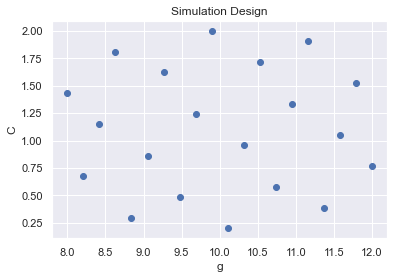

In [5]:
plt.scatter(t_sim[0:20,1],t_sim[0:20,0])
plt.xlabel("g");plt.ylabel("C"),plt.title("Simulation Design")

In [6]:
data.transform_xt()
data.standardize_y()

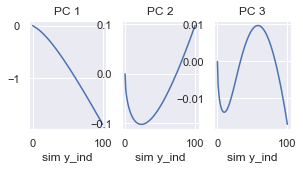

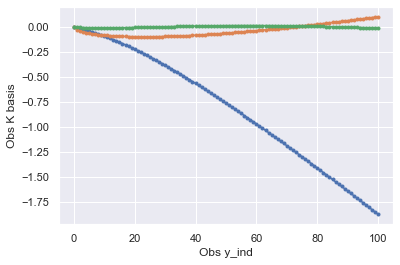

In [7]:
data.create_K_basis(3)
data.plot_K_basis()

In [8]:
data.create_D_basis('linear')
print(data)

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 101, obs y dimension 3
n  =     4 (number of observed data)
m  =    80 (number of simulated data)
p  =     2 (number of inputs)
q  =     2 (number of additional simulation inputs to calibrate)
pu =     3 (transformed response dimension)
pv =     2 (transformed discrepancy dimension)



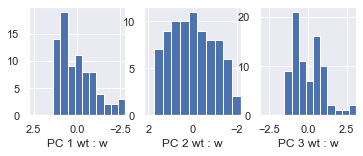

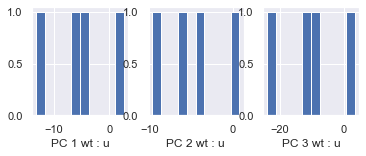

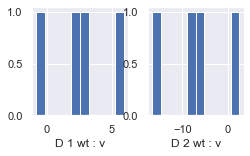

In [9]:
data.plot_K_weights()
data.plot_K_residuals()

In [10]:
model = setup_model(data)
cachefile_name='ball_drop_2.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name):
   model=pickle.load(open(cachefile_name, "rb" ))
else:
    model.tune_step_sizes(50, 20)
    model.do_mcmc(5000)
    pickle.dump(model, open( cachefile_name, "w+b" ))

lamWOs initialized outside default bounds [60, 1e5]; setting initial value to 1e5 - 1.


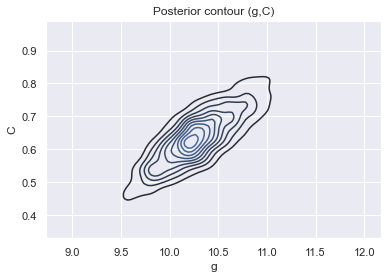

In [11]:
samples_dict = {p.name: p.mcmc_to_array(trim=1000,untransform_theta=True) for p in model.params.mcmcList}

# posterior contour for C,g
theta = samples_dict['theta']
import seaborn as sns
plt.xlabel("g");plt.ylabel("C");plt.title("Posterior contour (g,C)")
sns.kdeplot(theta[:,1], theta[:,0],)

theta 0.6375764441549271 0.08524505578440286
theta 10.305926025586478 0.3811831998370036
betaV 1.3645372582476725 2.6938617472790276
betaV 1.1001107294103565 2.306832144215073
betaU 0.24124942628926813 0.13479333257061615
betaU 0.8341776148689034 0.3210009072563278
betaU 0.21415880797259618 0.06599170393094574
betaU 0.07236606365019858 0.020538343532959046
betaU 0.05233986420954009 0.027247647249751573
betaU 0.11129071063403034 0.05706491500712537
betaU 0.883910793321751 0.164845790927177
betaU 0.34992035955191764 0.08198368633640808
betaU 0.6586416596634992 0.48267904688022356
betaU 0.8857121510782764 0.4957614433522766
betaU 2.7011407033219568 0.4846537056837015
betaU 0.034596362354343886 0.015590230492817695
lamVz 1045.2297054416665 989.7449474604646
lamUz 0.35538733099701164 0.05474941802741811
lamUz 0.3723846654993421 0.06656243788351314
lamUz 0.441438362558633 0.1151329785095765
lamWs 7586.177158520916 1439.607911035699
lamWs 5983.036656882418 1276.5219655695812
lamWs 2555.726208

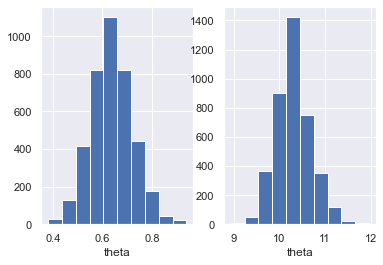

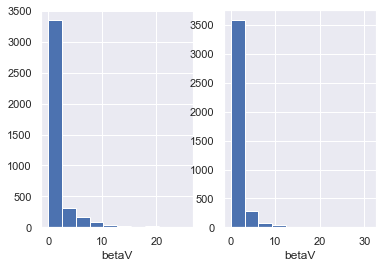

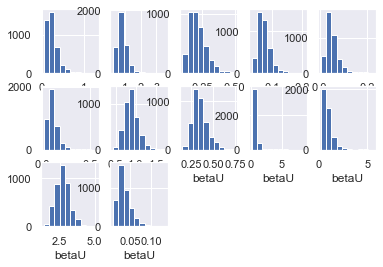

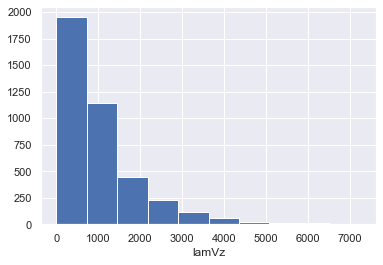

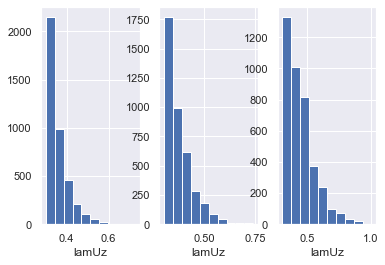

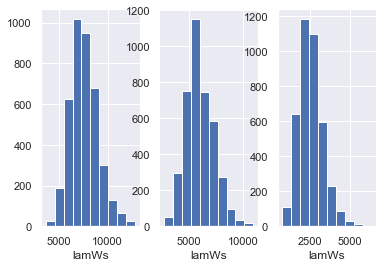

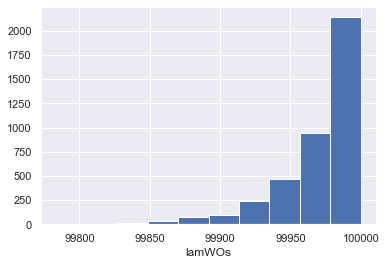

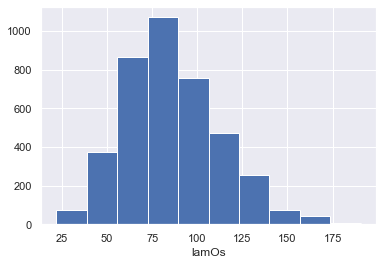

In [12]:
for i, k in enumerate(samples_dict.keys()):
    param_shape = samples_dict[k].shape[1]
    if param_shape >= 5:
        ncol = 5
        nrow = int(np.ceil(param_shape / ncol))
    else:
        ncol = param_shape
        nrow = 1
    plt.figure(i)
    for j in range(param_shape):
        plt.subplot(nrow, ncol, j + 1)
        plt.hist(samples_dict[k][:, j])
        plt.xlabel(k)
        print(k,np.mean(samples_dict[k][:, j]),np.std(samples_dict[k][:, j]))

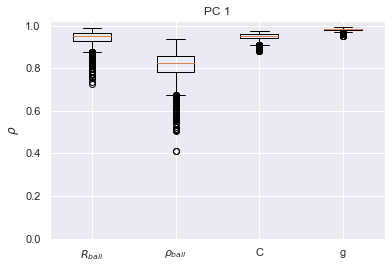

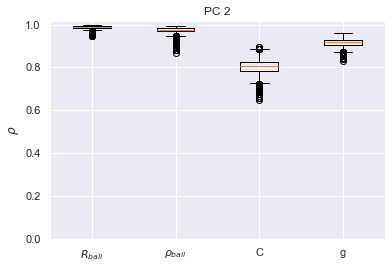

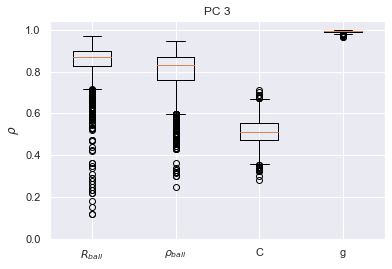

In [31]:
p = 2
q = 2
pu = 3
# rho box plots
bu = samples_dict['betaU']
ru = np.exp(-bu / 4)
for i in range(pu):
    r = ru[:, ((p+q)*i):((p+q)*i)+(p+q)]
    plt.boxplot(r)
    plt.xticks([1,2,3,4],[r'$R_{ball}$',r'$\rho_{ball}$','C','g'])
    plt.yticks(np.arange(0,1.2,.2))
    plt.ylabel(r'$\rho$')
    plt.title('PC {}'.format(i+1))
    plt.show()